# PyTorch Paper Replicating

This file will focus on replicating a Machine Learning research paper and creating a Vision Transformer (ViT) from scratch.

### What is paper replicating?

The goal of paper replicating is to replicate the most recent advances in Machine Learning which tend to be published in papers. Instead of using someone else's code, the focus here is to transform images, diagrams, math and text into usable code, in this case, PyTorch code.

### Where can code examples of Machine Learning research papers be found?

There is a lot of research in Machine Learning, so staying on top of the most recent advances is not easy. Said this, there are several places to find relevant papers.

Some useful resources include:
* arXiv
* AK Twitter
* Papers with Code
* lucidrains' `vit-pytorch` GitHub repository

### Which paper will be replicated?

The paper this file will focus on An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (ViT paper)
https://arxiv.org/abs/2010.11929

The Transformer neural network architecture was originally introduced in the Machine Learning research paper Attention is all you need
https://arxiv.org/abs/1706.03762

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism as its primary learning layer. This is similar to how Convolutional Neural Networks use convolutions as their primary learning layer.

The Attention Mechanism is more thoroughly explained here:
https://www.geeksforgeeks.org/ml-attention-mechanism/

As suggested by its name, the Vision Transformer (ViT) architecture was designed to adapt the original Transformer architecture to vision problems.

The original Vision Transformer has been through several iterations over the past couple of years, but we will focus on replicating the original.

For the rest of this project, we will refer to the Vision Transformer as ViT while referring to the original Machine Learning research paper as ViT paper.

## 0. Setup

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Could not find going_modular scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Zero-To-Mastery-Pytorch
    !mv Zero-To-Mastery-Pytorch/Fundamentals/going_modular .
    !mv Zero-To-Mastery-Pytorch/Fundamentals/helper_functions.py .
    !rm -rf Zero-To-Mastery-Pytorch
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it
[INFO] Could not find going_modular scripts. Downloading them from GitHub.
Cloning into 'Zero-To-Mastery-Pytorch'...
remote: Enumerating objects: 635, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 635 (delta 7), reused 0 (delta 0), pack-reused 617 (from 1)
Receiving objects: 100% (635/635), 113.18 MiB | 12.95 MiB/s, done.
Resolving deltas: 100% (121/121), done.
Updating files: 100% (352/352), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s

The ViT paper states the use of a batch size of 4096, which is considerably bigger than the batch size of 32 we have been using so far. However, we will stick with 32 because due to hardware limitations, handling batches of 4096 would be challenging.

In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79c0f45fa550>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

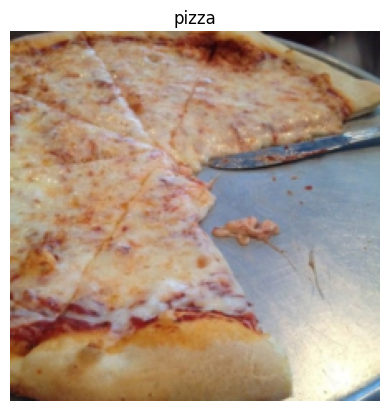

In [9]:
plt.imshow(image.permute(1, 2, 0)) # rearrange to suit matplotlib (go from [CHW] to [HWC])
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the ViT paper: an overview

### 3.1 Inputs and Outputs, Layer and Blocks

Neural networks are composed of layers, which can be grouped together into blocks. Said blocks can then be stacked together to provide a more thorough architecture.

Here is a breakdown of these:

* Layer: takes an input, performs a function on it, returns an output.
* Block: a collection of layers, takes an input, performs a series of functions on it, returns an output.
* Architecture (or model): a collection of blocks, takes an input, performs a series of functions on it, returns an output.

When replicating a paper, one must do it layer by layer, block by block, function by function.

### 3.2 What is ViT made of?

The ViT model paper has many details, but our focus of analysis are three resources:

1. Figure 1: gives an overview of the model in a graphical sense. You could almost recreate the architecture with this figure alone.
2. Four equations in section 3.1: These equations give a little bit more of a mathematical grounding to the colored blocks in Figure 1.
3. Table 1: This table shows the various hyperparameter settings for different ViT model variants.

#### 3.1.2 Figure 1

The main analysis of this section is around two features:

1. Layers
2. Blocks

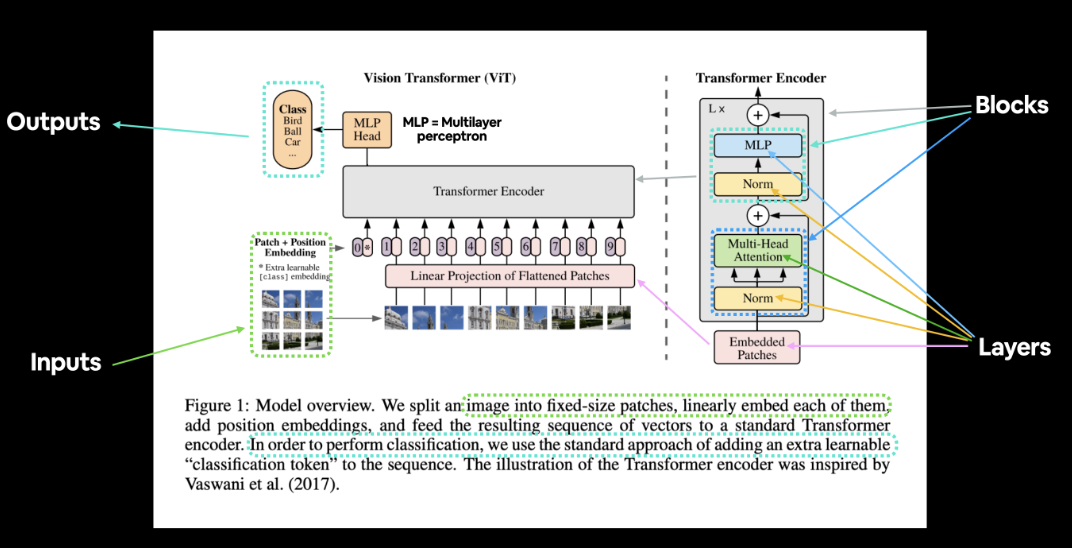

The ViT Architecture is comprised of several stages:

* **Patch + Position Embedding (inputs)**: Converts the input image into a sequence of image patches. A position number is then added given that transformers are almost a type of content based set operation. Hence, in order for it to retain positional information, it is assigned a position number and is passed to the self attention.
* **Linear Projection of Flattened Patches (Embedded Patches)**: The image patches get turned into an embedding which are essentially learnable representations. This extracts more data and meanings from the image patches, and can improve with training.
* **Norm**: Short for Layer Normalization or LayerNorm. It is a technique for regularizing (reducing overfitting) in a neural network. It can be used through `torch.nn.LayerNorm()`
* **Multi-Head Attention**: The model employs a MSA layer which allows it to focus on multiple parts of the input sequences simultaneously. This can be used through `torch.nn.MultiheadAttention()`
* **Multilayer Perceptron (MLP)**: A MLP can often refer to any collection of feedforward layers, which in PyTorch are a collection of layers with a `forward()` method. In the ViT paper, the authors refer to this as a 'MLP Block', which contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between. This is detailed in section 3.1, which is complemented by a `torch.nn.Dropout()` layer after each, detailed in Appendix B.1.
* **Transformer Encoder**: The Transformer Encoder is a collection of the layers listed above. These are complemented by two skip (or residual) connections inside the Transformer's encoder (the "+" symbols). This means that the inputs are fed directly to immediate layers as well as subsequent layers. This is benefitial because it allows that at the start of the training, when the gradient signal is still being initialized, the second signal goes through without any delay due to initialization. Hence, the lower layers can start training on this signal, and then incorporate the gradient once it is propagated through the block. Overall, it facilitates gradient flow, helps the model learn modifications rather than complete transformations, and stabilizes training.
* **MLP Head**: This is the output layer, it converts the learned features of an input to a class output. This could be seen as the classifier head.

Given the detail of the paper, everything could be coded from scratch, which would be a challenging and educative exercise. However, pre-existing PyTorch layers have already been extensively tested and performance checked.

#### 3.2.2 The Four Equations

The main equations of section 3.1 go over the math behind the ViT architecture.

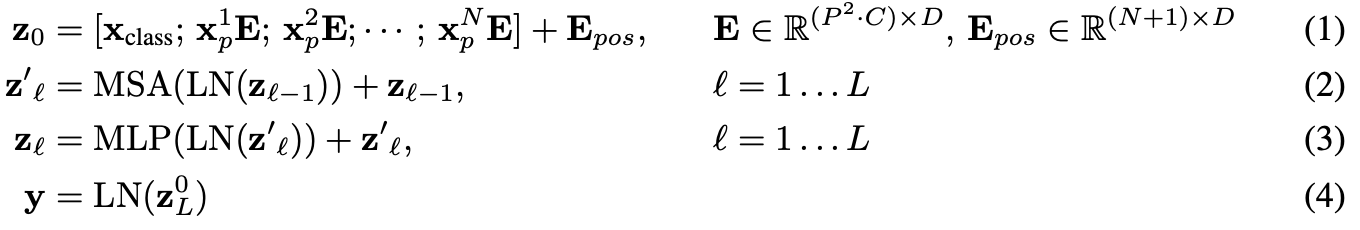

Below is a description of the four equations with the number being the equation number. The descriptions are cited from the paper:
1. The Transformer uses constant latent vector size D through all of its layers, so we
flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
2. The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).
3. Same as equation 2.
4. Similar to BERT’s [class] token, we prepend a learnable embedding to the sequence of embedded patches ($z_0^0$ = $x_{class}$), whose state at the output of the Transformer encoder ($z_L^0$) serves as the image representation y.


Here is a breakdown of the descriptions with Figure 1

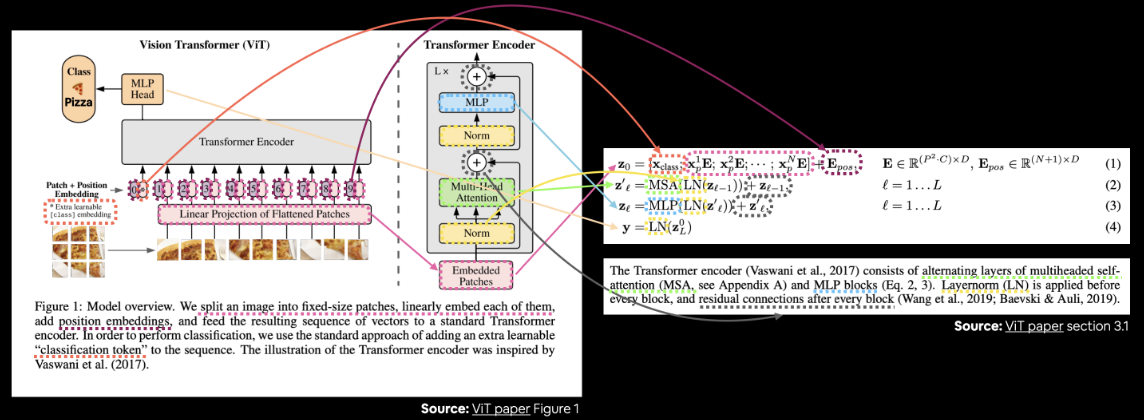

Throughout the equations, "z" is always the output of a particular layer.

1. $z_0$ os the output of the initial embedding layer.
2. $z_l^{'}$ is the output a particular layer prime, or an intermediary value of z.
3. $z_l$ is the output of a particular layer

Additionally, y is the overall output of the architecture.


#### 3.2.3 Equation 1 Overview

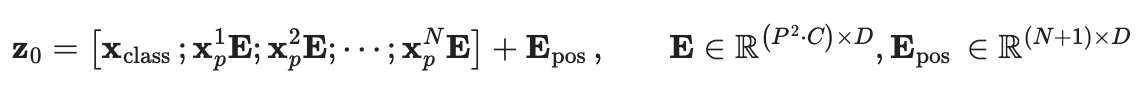

This equation deals with the class token, patch embedding and position embedding of the input image. The bold capital letter E stands for the embedding.

In vector form, the embedding might look something like:
```
x_input = [class_token, image_patch_1, image_patch_2,
image_patch_3...] + [class_token_position,
image_patch_1_position, image_patch_2_position,
image_patch_3_position...]
```

Here, each element in the vector is learnable (`requires_grad=True`)



#### 3.2.4 Equation 2 Overview

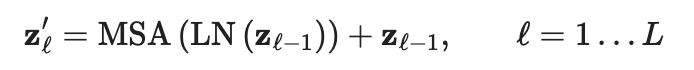

This equation states that every layer from 1 through L which is the total number of layers, there is a MSA wrapping a LN.

This is complemented by the skip/residual connection which is the addition at the end.

All of this is equivalent to the "MSA Block" layer.

This might look like:
```
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```


#### 3.2.5 Equation 3 Overview

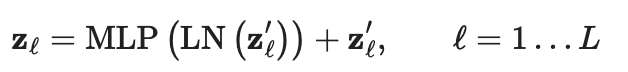

This equation states that for every layer from 1 through L there is also a MLP wrapping a LN.

The addition at the end is also showcasing a skip/residucal connection.

All of this is equivalent to the "MLP Block" layer.

This might look like:
```
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

#### 3.2.6 Equation 4 Overview

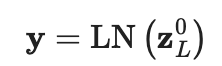

This applies to the last layer L, where the y output is said to be the 0 index token of z wrapped in a LN.

In our case, the 0 index of `x_output_MLP_block`

`y = Linear_Layer(LN_layer(x_output_MLP_block[0]))`



#### Exploring Table 1

The final piece of the ViT architecture that will be focused on for now is Table 1.

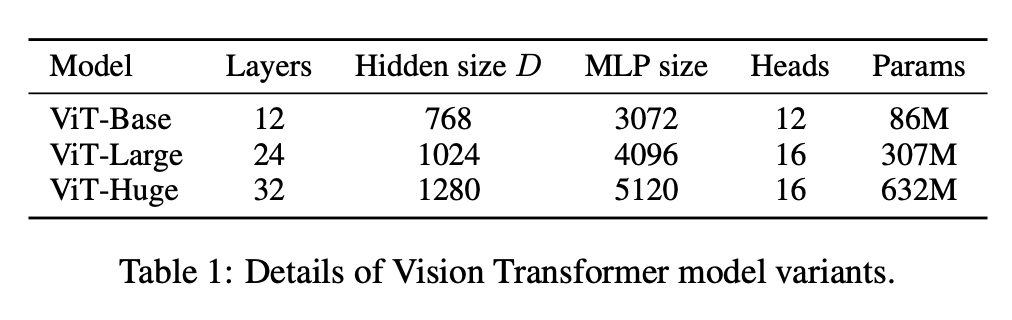

The above table showcases the hyperparameters of the ViT architectures, where we will begin with the ViT-Base.

Here is a breakdown of the hyperparameters:
* **Layers**: Number of Transformer Encoder blocks (each contains a MSA and MLP block)
* **Hidden Size D**:  The embedding dimension throughout the architecture. This is the size of the vector that our image gets turned into when it gets patched and embedded. A larger embedding captures more information while also becoming more computationally expensive.
* **MLP Size**: Number of hidden units in the MLP layers
* **Heads**: Number of heads in the Multi-Head Attention layers
* **Params**: Total number of parameters of the model. More parameters lead to better performance while also becoming more computationally expensive.



### 3.3 Replicating Papers Workflow

1. Read the whole paper end-to-end once (get an idea of the main concepts).
2. Go back through each section identifying links and connections that provide insight into how it might be turned into code.
3. Repeat step 2 until you have a good outline
4. Use [mathpix.com](https://mathpix.com/) to turns any sections of the paper into markdown/LaTex for the notebooks.
5. Replicate the simplest model version possible
6. Look for more examples when stuck

##4. Equation 1: Split data into patches and creating the class, position and patch embedding.

If you can represent your data in a good, learnable way (as embeddings are learnable representations), a learning algorithm is likely to perform well on them.

The first step we will do is work on the patch embeddings. Recall an embedding is a learnable representation of some form and is often a vector. It is important to note that embeddings are learnable because this means it can improve over time.

We will use the opening paragraph of section 3.1 of the ViT paper.

> An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2 D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

Regarding size, we are dealing with images shapes, where in a line from Table 3 of the paper it is stated that:



> Training reoslution is **224**.

Let's break down the text above.

* D is the size of the patch embeddings. Table 1 shows the various D values that can be used for various sized ViT models.
* The image starts as 2D with size $H \times W \times C$
 * $(H, W)$ is the resolution of the original image
 * C is the number of channels
* The image is converted to a sequence of flattened 2D patches with size $N \times (P^2 \cdot C)$.
 * $(P, P)$ is the resolution of each image patch (patch size)
 * $N = HW / P^2$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.  

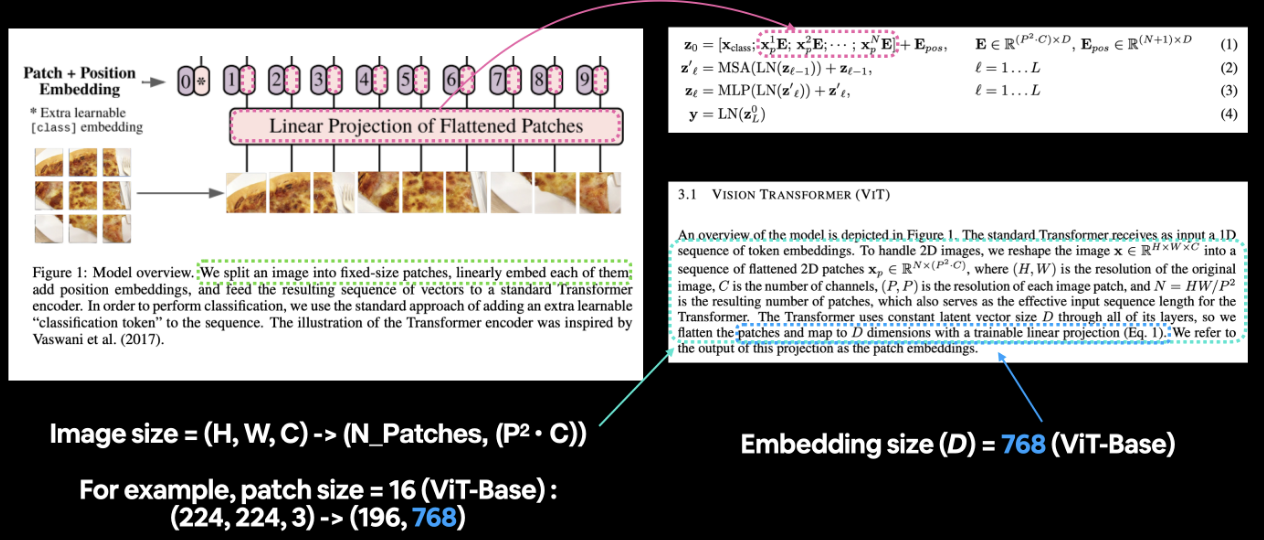

### 4.1 Calculating Patch Embedding Input and Output Shapes by Hand

Based on Table 5 from the paper, we can find the accuracy of the Vision Transformer on various datasets, with the Patch Size as a hyperparameter.

Within the ViT-Base uses, an accuracy of 98.13% is achieved with a Patch Size of 16. Hence, we will use this value for now.

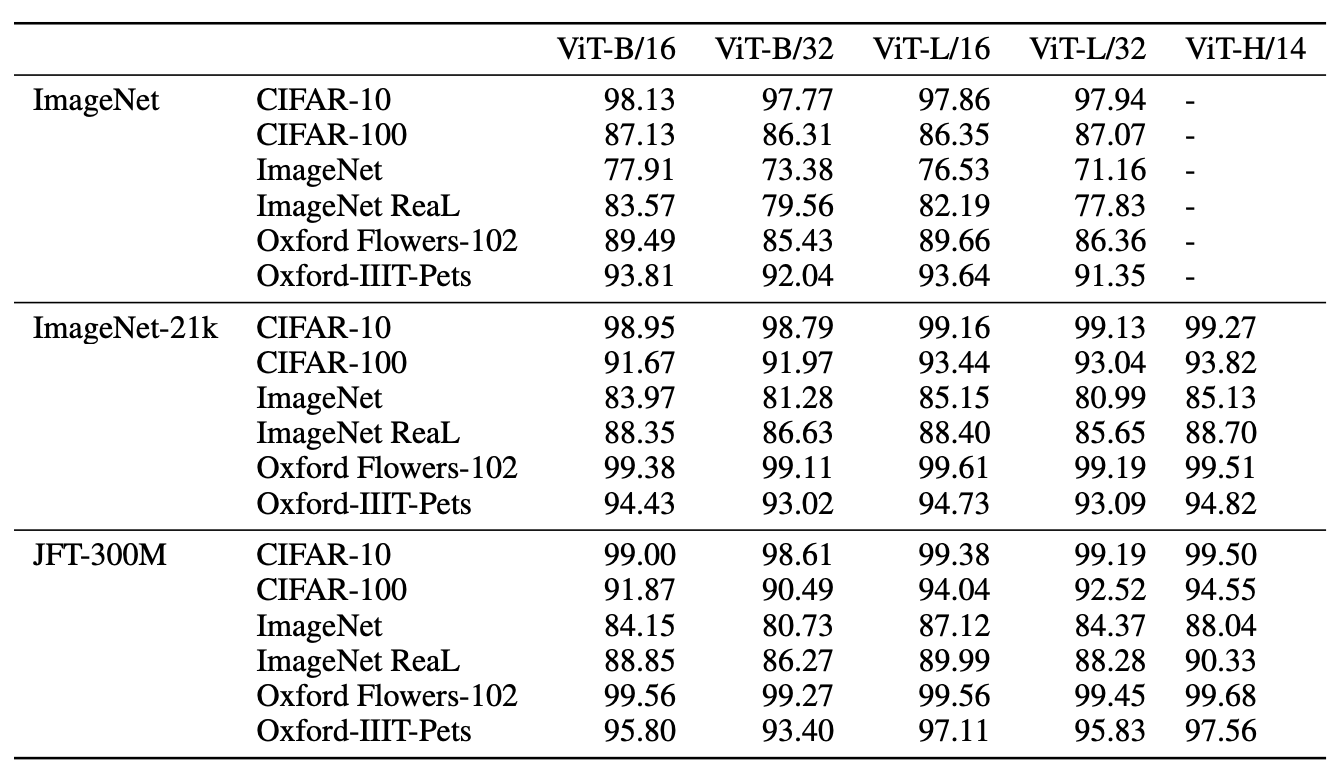

In [10]:
height = 224 # Training Resolution is 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height {height} (H), width {width} (W), and patch size {patch_size} (P): {number_of_patches}")

Number of patches (N) with image height 224 (H), width 224 (W), and patch size 16 (P): 196


To replicate the input and output shapes of the patch embedding layer, we must recall:

* Input: the image starts as 2D with size $H \times W \times C$
* Output: the image gets converted to a sequence of flattened 2D patches with size $N \times (P^2 \cdot C)$.

In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.2 Turning a Single Image into Patches

Now we have the input and output shapes of the patch embedding layer. From here, we can start creating it.

Firstly, we will see what it means to turn an image into patches.

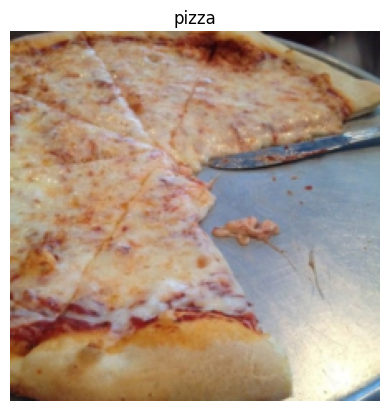

In [12]:
plt.imshow(image.permute(1, 2, 0)) # Changing CHW -> HWC for matplotlib
plt.title(class_names[label])
plt.axis(False);

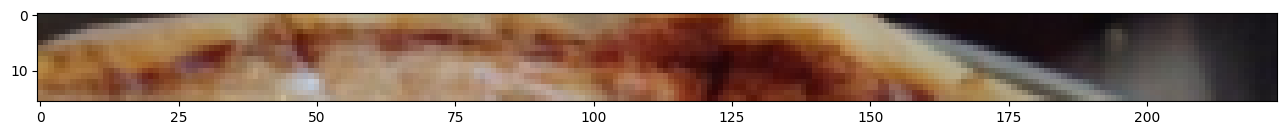

In [13]:
permuted_image = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(permuted_image[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


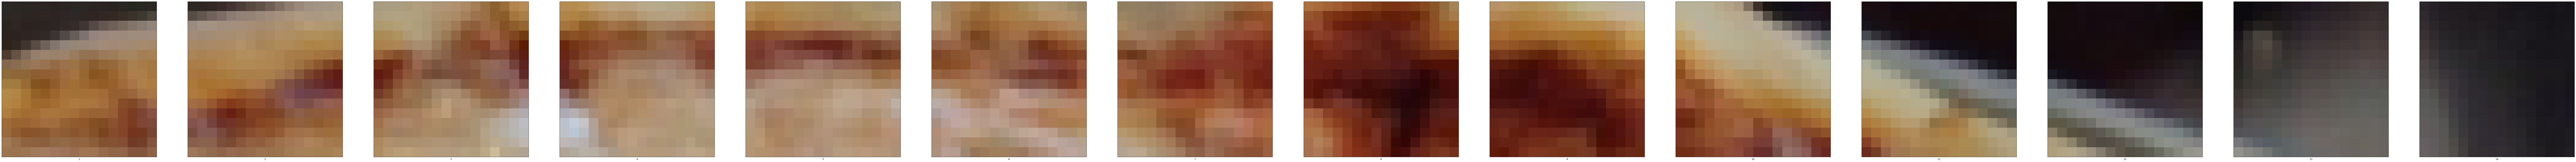

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(number_of_patches, number_of_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(permuted_image[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Seeing how the patches work for an individual image, we can now do it for the entire image.

To do so, we iterate through the indexes for height and width and plot each patch as it's own subplot.

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


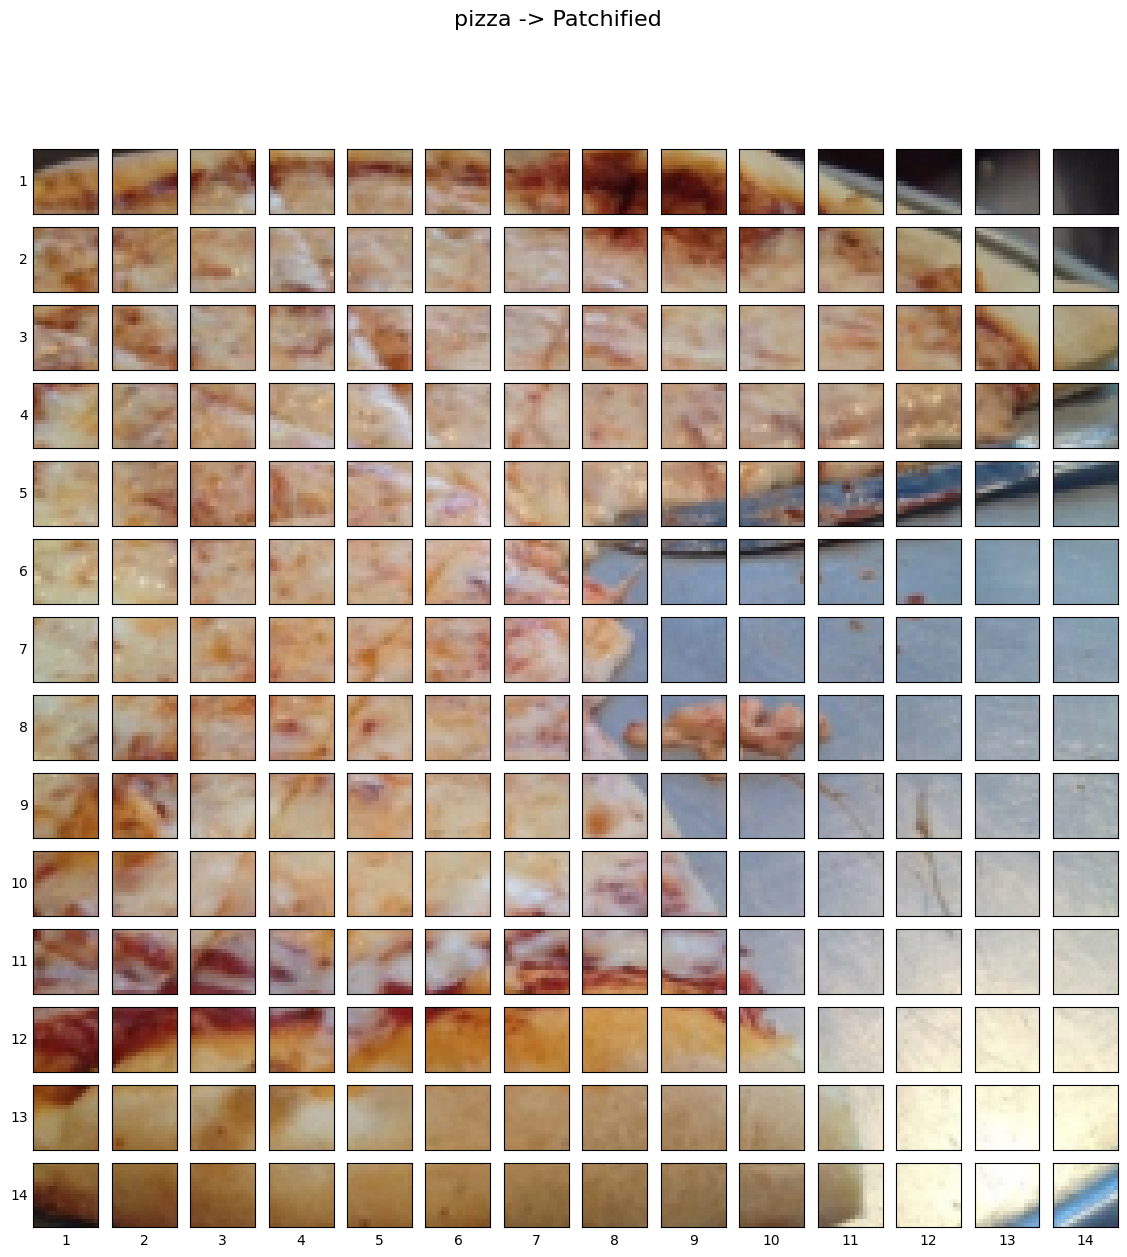

In [15]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Series of subplots
fig, axs = plt.subplots(nrows= img_size // patch_size, # can only handle ints
                        ncols= img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Looping throught the width and height of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

    # Plot permuted image (CHW -> HWC)
    axs[i, j].imshow(permuted_image[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]); # all color channels
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")

    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()


### 4.3 Creating image patches with `torch.nn.Conv2d()`